## IMPORT LIBRARIES

In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input,LSTM
import IPython.display as ipd
import json
import pretty_midi
import fluidsynth

## PATH TO SAMPLE, TRAINING AND TEST DATA

In [4]:
MUSIC_TRAIN_PATH = 'train/maestro-v3.0.0'
MUSIC_TEST_PATH = 'test/maestro-v3.0.0'
MUSIC_TEST_OUTPUT = 'output'
MUSIC_SAMPLE_PATH = 'sample'
JSON_DATA_FILE = 'processed_data.json'

## MODEL PARAMETERS

In [5]:
HIDDEN_STATE_SIZE = 128
BATCH_SIZE = 1
LEARNING_RATE = 1e-3
NUM_EPOCHS = 10
DECAY_RATE = 1e-5
LOSS_FN = 'categorical_crossentropy'
METRICS = ['accuracy']
DROPOUT_RATE = 0.2
RECURRENT_DROPOUT_RATE = 0.2
VALIDATION_SPLIT = 0.2

## LOAD TRAINING DATA AND PARAMETERS FROM JSON FILE

In [6]:
train_data = None
with open(os.path.join(MUSIC_SAMPLE_PATH, JSON_DATA_FILE)) as json_data_file:
    train_data = json.loads(json.load(json_data_file))

X_train = np.array(train_data['input'])
y_train = np.array(train_data['output'])
train_note_velocity_mean_var = train_data['note_velocities_mean_var']
train_token_to_notes = train_data['tokens_to_notes_dict']

In [7]:
NUM_UNIQUE_NOTES = train_data['num_unique_notes']
KEY_FPS = train_data['key_fps']
HOP_LENGTH = train_data['hop_length']
WINDOW_SIZE_IN_KEYS = train_data['windows_size_in_keys']
SAMPLE_RATE = KEY_FPS * HOP_LENGTH
FRAME_SIZE = WINDOW_SIZE_IN_KEYS * HOP_LENGTH
MAX_PIANO_FREQ = train_data['max_piano_freq']

In [8]:
print(X_train.shape)
print(y_train.shape)

(1, 7757, 2048)
(1, 7757)


## LOAD TEST DATA

In [9]:
test_data = None
with open(os.path.join(MUSIC_SAMPLE_PATH, JSON_DATA_FILE)) as json_data_file:
    test_data = json.loads(json.load(json_data_file))

X_test = np.array(test_data['input'])
y_test = np.array(test_data['output'])
test_note_velocity_mean_var = test_data['note_velocities_mean_var']
test_token_to_notes = test_data['tokens_to_notes_dict']

In [10]:
print(X_test.shape)
print(y_test.shape)

(1, 7757, 2048)
(1, 7757)


## CONVERT OUTPUT LABEL AT EACH TIME-STEP TO ONE-HOT ENCODING

In [11]:
def convert_label_to_one_hot(output_labels):
    output_one_hot = []
    for sample in range(output_labels.shape[0]):
        sample_output = output_labels[sample,:]
        sample_output_one_hot = np.zeros((sample_output.size, sample_output.max()+1))
        sample_output_one_hot[np.arange(sample_output.size), sample_output] = 1
        output_one_hot.append(sample_output_one_hot)
    
    return np.array(output_one_hot)

In [12]:
y_train = convert_label_to_one_hot(y_train)
y_test = convert_label_to_one_hot(y_test)

In [13]:
print(y_train.shape)
print(y_test.shape)

(1, 7757, 1505)
(1, 7757, 1505)


## ENCODER DECODER NETWORK

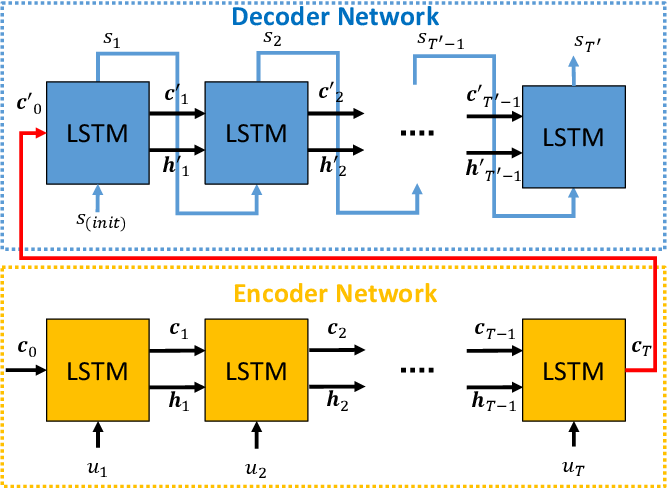

In [14]:
ipd.Image("images/encoder_decoder.png", width=900, height=540)

## SPECIFY MODEL ARCHITECTURE

In [15]:
encoder_inputs = Input(shape=(None, MAX_PIANO_FREQ))
encoder = LSTM(HIDDEN_STATE_SIZE, return_state=True)
_, state_h, state_c = encoder(encoder_inputs)

encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, NUM_UNIQUE_NOTES))
decoder_lstm = LSTM(HIDDEN_STATE_SIZE, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(NUM_UNIQUE_NOTES, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 2048)  0           []                               
                                ]                                                                 
                                                                                                  
 input_2 (InputLayer)           [(None, None, 1505)  0           []                               
                                ]                                                                 
                                                                                                  
 lstm (LSTM)                    [(None, 128),        1114624     ['input_1[0][0]']                
                                 (None, 128),                                                 

## CHOOSE OPTIMIZER AND COMPILE MODEL

In [16]:
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE, decay=DECAY_RATE)
model.compile(loss=LOSS_FN, optimizer=optimizer, metrics=METRICS)

## TRAIN MODEL

In [17]:
decoder_target_data = np.concatenate((np.zeros((y_train.shape[0], 1, y_train.shape[2])), y_train), axis=1)[:,:-1,:]
model.fit([X_train, y_train], decoder_target_data,
          batch_size=BATCH_SIZE,
          epochs=NUM_EPOCHS,
          #validation_split=VALIDATION_SPLIT
)

Epoch 1/10
1/1 [==============================] - 27s 27s/step - loss: 7.3158 - accuracy: 3.8675e-04
Epoch 2/10
1/1 [==============================] - 23s 23s/step - loss: 7.3107 - accuracy: 0.0045
Epoch 3/10
1/1 [==============================] - 23s 23s/step - loss: 7.3060 - accuracy: 0.0349
Epoch 4/10
1/1 [==============================] - 23s 23s/step - loss: 7.3009 - accuracy: 0.1145
Epoch 5/10
1/1 [==============================] - 25s 25s/step - loss: 7.2955 - accuracy: 0.1461
Epoch 6/10
1/1 [==============================] - 26s 26s/step - loss: 7.2895 - accuracy: 0.1671
Epoch 7/10
1/1 [==============================] - 25s 25s/step - loss: 7.2825 - accuracy: 0.1667
Epoch 8/10
1/1 [==============================] - 25s 25s/step - loss: 7.2735 - accuracy: 0.1467
Epoch 9/10
1/1 [==============================] - 27s 27s/step - loss: 7.2607 - accuracy: 0.1064
Epoch 10/10
1/1 [==============================] - 26s 26s/step - loss: 7.2387 - accuracy: 0.0896


## INFERENCE MODEL

In [18]:
encoder_model = Model(encoder_inputs, encoder_states)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 2048)]      0         
                                                                 
 lstm (LSTM)                 [(None, 128),             1114624   
                              (None, 128),                       
                              (None, 128)]                       
                                                                 
Total params: 1,114,624
Trainable params: 1,114,624
Non-trainable params: 0
_________________________________________________________________


In [19]:
decoder_state_input_h = Input(shape=(HIDDEN_STATE_SIZE,), name="input_3")
decoder_state_input_c = Input(shape=(HIDDEN_STATE_SIZE,), name="input_4")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

In [20]:
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_outputs = decoder_dense(decoder_outputs)

In [21]:
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, 1505)  0           []                               
                                ]                                                                 
                                                                                                  
 input_3 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 lstm_1 (LSTM)                  [(None, None, 128),  836608      ['input_2[0][0]',          

## INFERENCE

In [28]:
def decode_sequence(input_seq, encoder_model, decoder_model, batch_size=BATCH_SIZE):
    # Shape of target sequence : (BATCH_SIZE, NUM_TIME_STEPS, NUM_UNIQUE_NOTES)

    states = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1, NUM_UNIQUE_NOTES))
    output_seq = []
    time_step = 0
    
    while time_step < input_seq.shape[1]:
        output_current, h, c = decoder_model.predict([target_seq]+states)
        output_note_indx = np.argmax(output_current[0, -1, :])
        output_seq.append(output_current)

        target_seq = np.zeros((1, 1, NUM_UNIQUE_NOTES))
        target_seq[0, 0, output_note_indx]=1
        
        states = [h, c]
        time_step += 1

    output_seq = np.array(output_seq).reshape((input_seq.shape[0], input_seq.shape[1], NUM_UNIQUE_NOTES))
    return output_seq

In [29]:
output_seq = decode_sequence(X_test, encoder_model, decoder_model)
output_seq.shape

(1, 7757, 1505)

## CONVERT PREDICTION TO MIDI

In [30]:
def convert_prediction_to_midi(indx, output, token_to_notes=test_token_to_notes, note_vel_mean_var=test_note_velocity_mean_var):
    assert (output.shape[-1] == NUM_UNIQUE_NOTES)
    notes_seq = [token_to_notes[str(x)] for x in output.argmax(1)]
    instrument = pretty_midi.Instrument(0, name='piano')
    note_details = {}
    pm = pretty_midi.PrettyMIDI()
    
    for index, note in enumerate(notes_seq):
        if note != '':
            notes = note.split(',')
            for i in notes:
                note_vel = np.random.normal(note_vel_mean_var[indx][0][int(i)], note_vel_mean_var[indx][1][int(i)])
                if int(i) not in note_details:
                    note_details[int(i)]=[[index], [index], [note_vel]]
                else:
                    if note_details[int(i)][1][-1]==(index-1):
                        note_details[int(i)][1][-1]=index
                    else:
                        note_details[int(i)][0].append(index)
                        note_details[int(i)][1].append(index)
                        note_details[int(i)][2].append(note_vel)

    for note in note_details:
        for start_time, end_time, note_velocity in zip(note_details[note][0], note_details[note][1], note_details[note][2]):
            pretty_note = pretty_midi.Note(
                velocity=int(note_velocity),
                pitch=note,
                start=start_time/KEY_FPS,
                end=end_time/KEY_FPS
            )
            instrument.notes.append(pretty_note)
    
    instrument.notes.sort(key=lambda x: x.start)
    pm.instruments.append(instrument)
    return pm

In [31]:
file_indx = 0
pmidi = convert_prediction_to_midi(file_indx, output_seq[file_indx])
pmidi.write(os.path.join(MUSIC_TEST_OUTPUT, test_data['filenames'][file_indx]+'.midi'))